# Capstone notebook: Classification of Stockholm neighborhoods using Foursquare data
Oxana Falk, July 2019

## Summary
This assignment aims to analyze different neighborhoods of Stockholm by exploring venues
surrounding the metro stations and describe different clusters of neighborhoods. Unsupervised
machine learning method, K-means clustering, is used to carry out the analysis. In total, three
clusters were identified and analyzed. The main conclusion is that there are significant
differences between the clusters in number of venues surrounding metro stations and what
venues are the most common ones in the city center compared to the other areas in Stockholm.
However, when it comes to the most common categories of venues, all the clusters look similar
to each other, indicating that Stockholm is quite homogeneous in terms of available venue
categories.

## 1. Introduction
Stockholm is one of the five fastest growing regions in Europe. The city population has grown by
almost 30 percent during last 20 years and in 2020, Stockholm is expected to have one million
inhabitants.
This project aims to describe different parts of Stockholm by studying neighborhoods surrounding
metro stations. There are 100 stations in use of which 82 belong to the city of Stockholm and the
rest in neighboring municipalities that are relatively close to the city center.
The result can be useful for someone who is planning to move to Stockholm and would like to
find a place that fits their lifestyle and interests.
## 2. Data


Let's get all the packages that are going to be used in this assigment:

In [129]:
!pip install beautifulsoup4
!pip install lxml
!pip install requests
from bs4 import BeautifulSoup
import requests
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np

# convert an address into latitude and longitude values
!pip install geopy
from geopy.geocoders import Nominatim

# Matplotlib and associated plotting modules
!pip install matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter, defaultdict

# map rendering library
!pip install folium
import folium

# library to handle JSON files
import json

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize
import xml.etree.ElementTree as et 

print("Done!")

Done!


### 2.1 Data sources and 2.2 Data cleaning

Let's get a list of the metro stations in Stockholm and their geographical coordinates:

In [958]:
source=requests.get('https://sv.wikipedia.org/w/index.php?title=Lista_%C3%B6ver_tunnelbanestationer_i_Stockholm&oldid=46033661').text
soup = BeautifulSoup(source,'lxml')
table=soup.find('table',{'class':'sortable wikitable'})
table_rows = table.find_all('tr')
res = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td if tr.text.strip()]
    if row:
        res.append(row)
metro_st = pd.DataFrame(res, columns=["Station", "Line", "Year", "Distance", "Municipality", "Type", "Longitude", "Latitude"])
metro_st.head()

,Station,Line,Year,Distance,Municipality,Type,Longitude,Latitude
0,Slussen,Grön,1950,"1,5",Stockholms kommun,Betongstation,18.072327,59.319493
1,Medborgarplatsen,Grön,1950,"2,1",Stockholms kommun,Betongstation,18.073550,59.314342
2,Skanstull,Grön,1950,"2,7",Stockholms kommun,Betongstation,18.076229,59.307852
3,Gullmarsplan,Grön,1950,"3,8",Stockholms kommun,"Ytstation, delvis överbyggd av betong",18.080768,59.299114
4,Skärmarbrink,Grön,1950,"4,5",Stockholms kommun,Ytstation,18.090440,59.295366


For the metro station data, the following cleaning was performed:
* Only opened and functioning stations were used.
* Duplicates were removed. In the original table there are some stations that are
    represented on multiple metro lines but since the fact that those stations have the same
    name and coordinates and metro lines are not of interest for this project, only unique
    combinations of station names and coordinates were kept.
* Information about previous station names was removed since it's not relevant for this
    assignment.

In [964]:
# Keep only opened and functioning stations
metro_st_1=metro_st[metro_st['Year'].astype(str).str.isdigit()]

# Keep only the columns that are needed for this project and convert Distance to a numeric variable with '.' as a decimal separator
metro_st_2=metro_st_1[['Station','Longitude','Latitude',"Distance"]]
metro_st_2['Distance'] = [x.replace(',', '.') for x in metro_st_2['Distance']]
metro_st_2['Distance'] = pd.to_numeric(metro_st_2['Distance'])

# Remove the duplicates among the stations
metro_st_3=metro_st_2.drop_duplicates(["Station"]).reset_index(drop=True)

# Remove information about the previous station name
metro_st_4=metro_st_3
metro_st_4['Station'] = metro_st_3['Station'].str.replace(r" \(.*\)","")
metro_st_4.head(5)

,Station,Longitude,Latitude,Distance
0,Slussen,18.072327,59.319493,1.5
1,Medborgarplatsen,18.073550,59.314342,2.1
2,Skanstull,18.076229,59.307852,2.7
3,Gullmarsplan,18.080768,59.299114,3.8
4,Skärmarbrink,18.090440,59.295366,4.5


Let's get the Foursquare Venue data. The average distance between two metro stations in Stockholm is approximately 1 km (both the arithmetic mean and the median). In order to avoid overlapping and to cover reasonable walking distance around each
station, the radius of the query was limited to 500 meters.

Let's start with findning coordinates for Stockholm:

In [965]:
address = 'Stockholm, Sweden'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Stockholm are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Stockholm are 59.3251172, 18.0710935.


Next step is to define Foursquare credentials:

In [966]:
CLIENT_ID = 'XXX' # my Foursquare ID (hidden in the public repository)
CLIENT_SECRET = 'XXX' # my Foursquare Secret (hidden in the public repository)
VERSION = '20190718' # Foursquare API version

Finally, let's get the venue data:

In [ ]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # radius around every metro station

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url
results = requests.get(url).json()

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [968]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Science Fiction Bokhandeln,Bookstore,59.324047,18.070682
1,Tweed,Cocktail Bar,59.324471,18.067696
2,Stortorget,Plaza,59.324973,18.070727
3,Barrels Burgers & Beer,Burger Joint,59.324685,18.068513
4,Stockholms Gästabud,Gastropub,59.325569,18.073991


In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=300):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Metro station', 
                  'Metro station Latitude', 
                  'Metro station Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Category']
    
    return(nearby_venues)

In [1045]:
sthlm_venues = getNearbyVenues(names=metro_st_4['Station'],
                                   latitudes=metro_st_4['Latitude'],
                                   longitudes=metro_st_4['Longitude']
                                  )

In [976]:
sthlm_venues.head()

,Metro station,Metro station Latitude,Metro station Longitude,Venue,Venue Latitude,Venue Longitude,Category
0,Slussen,59.319493,18.072327,Omnipollos hatt,59.318005,18.072143,Beer Bar
1,Slussen,59.319493,18.072327,Mosebacketerrassen,59.318490,18.075129,Beer Garden
2,Slussen,59.319493,18.072327,Akkurat,59.319809,18.068830,Pub
3,Slussen,59.319493,18.072327,Södra Teatern,59.318303,18.074403,Theater
4,Slussen,59.319493,18.072327,Oliver Twist,59.318282,18.070002,Pub


Looks good! Now, let's remove venue category "Metro station" since it's our entry variable and would only mislead the result of clustering:

In [980]:
sthlm_venues_1=sthlm_venues
sthlm_venues_1.drop(sthlm_venues_1[sthlm_venues_1['Category'] == 'Metro Station'].index, inplace=True)
sthlm_venues_1.head()

,Metro station,Metro station Latitude,Metro station Longitude,Venue,Venue Latitude,Venue Longitude,Category
0,Slussen,59.319493,18.072327,Omnipollos hatt,59.318005,18.072143,Beer Bar
1,Slussen,59.319493,18.072327,Mosebacketerrassen,59.318490,18.075129,Beer Garden
2,Slussen,59.319493,18.072327,Akkurat,59.319809,18.068830,Pub
3,Slussen,59.319493,18.072327,Södra Teatern,59.318303,18.074403,Theater
4,Slussen,59.319493,18.072327,Oliver Twist,59.318282,18.070002,Pub


Finally, let's download the list of Foursquare's main and lower level categories originally downloaded from https://developer.foursquare.com/docs/resources/categories but for now stored in my Github repository:

In [982]:
foursquare_cat=pd.read_csv('https://raw.githubusercontent.com/OxanaFalk/Coursera_Capstone/master/Foursquare_categories_20190718.txt')
foursquare_cat.head()

,Main category,Category,Code
0,Arts & Entertainment,Arts & Entertainment,4d4b7104d754a06370d81259
1,Arts & Entertainment,Amphitheater,56aa371be4b08b9a8d5734db
2,Arts & Entertainment,Aquarium,4fceea171983d5d06c3e9823
3,Arts & Entertainment,Arcade,4bf58dd8d48988d1e1931735
4,Arts & Entertainment,Art Gallery,4bf58dd8d48988d1e2931735


## 3. Methodology
### 3.1 Exploratory Data Analysis
#### 3.1.1 Stockholm metro
Let's visualize the map of Stockholm with metro stations on it (dark blue markers):

In [986]:
# create map of Stockholm
map_sthlm = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(metro_st_4['Latitude'], metro_st_4['Longitude'], metro_st_4['Station']):
#    label = '{}'.format(station)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='darkblue',
        fill=True,
        fill_color='beige',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sthlm)  
    
map_sthlm

Let's calculate some descriptive statictics for the distance from the city center:

In [985]:
metro_st_4.describe()

,Distance
count,100.000000
mean,7.997000
std,4.921165
min,0.000000
25%,4.500000
50%,7.300000
75%,10.900000
max,22.300000


#### 3.1.2 Foursquare data
To get the size of the dataframe with the venue data from Foursquare:

In [989]:
sthlm_venues_1.shape

(2332, 7)

In order to get some descriptive statistics over the main categories in the dataset, let's start with combining the Foursquare venue data with the Fourssquare main category data:

In [990]:
main_categories=sthlm_venues_1
main_cat=main_categories.merge(foursquare_cat, how='left', on='Category')
main_cat.head()

,Metro station,Metro station Latitude,Metro station Longitude,Venue,Venue Latitude,Venue Longitude,Category,Main category,Code
0,Slussen,59.319493,18.072327,Omnipollos hatt,59.318005,18.072143,Beer Bar,Nightlife Spot,56aa371ce4b08b9a8d57356c
1,Slussen,59.319493,18.072327,Mosebacketerrassen,59.318490,18.075129,Beer Garden,Nightlife Spot,4bf58dd8d48988d117941735
2,Slussen,59.319493,18.072327,Akkurat,59.319809,18.068830,Pub,Nightlife Spot,4bf58dd8d48988d11b941735
3,Slussen,59.319493,18.072327,Södra Teatern,59.318303,18.074403,Theater,Arts & Entertainment,4bf58dd8d48988d137941735
4,Slussen,59.319493,18.072327,Oliver Twist,59.318282,18.070002,Pub,Nightlife Spot,4bf58dd8d48988d11b941735


Let's calculate the occurences and the percentage of different venue categories in the dataset:

In [992]:
cat_grouped=main_cat.groupby('Main category')['Category'].count().reset_index()
cat_grouped['Percent'] = cat_grouped['Category']/cat_grouped['Category'].sum()*100
cat_grouped=cat_grouped.sort_values('Percent', ascending=False)
cat_grouped.round({'Percent': 1}) 

,Main category,Category,Percent
2,Food,1175,50.4
6,Shop & Service,429,18.4
4,Outdoors & Recreation,265,11.4
7,Travel & Transport,165,7.1
3,Nightlife Spot,155,6.6
0,Arts & Entertainment,113,4.8
5,Professional & Other Places,26,1.1
1,College & University,4,0.2


Let's explore the venues even on the detailed level and get the top 10 most common venues in the dataset:

In [993]:
cat_grouped_detail=main_cat.groupby('Category')['Main category'].count().reset_index()
cat_grouped_detail=cat_grouped_detail.sort_values('Main category', ascending=False)
cat_grouped_detail.head(10)

,Category,Main category
40,Café,122
209,Scandinavian Restaurant,113
192,Pizza Place,101
112,Grocery Store,80
17,Bakery,76
126,Hotel,69
114,Gym / Fitness Center,66
136,Italian Restaurant,65
229,Sushi Restaurant,55
237,Thai Restaurant,51


Now let's calculate the number of venues per metro station and get some descriptive statistics among with a boxplot:

In [994]:
venues_grouped = sthlm_venues_1.groupby('Metro station')['Venue'].count().reset_index()
venues_grouped.head()

,Metro station,Venue
0,Abrahamsberg,5
1,Akalla,13
2,Alby,4
3,Alvik,19
4,Aspudden,17


In [995]:
venues_grouped.describe()

,Venue
count,100.000000
mean,23.320000
std,28.884262
min,1.000000
25%,5.000000
50%,12.000000
75%,22.000000
max,100.000000


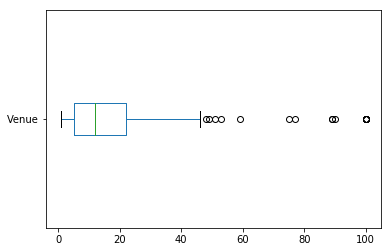

In [996]:
venues_grouped.plot.box(vert=False)

In order to explore the correlation between the number of venues and the distance from the city center, let's create a new dataframe that combines those variables:

In [998]:
dist_venues=venues_grouped
dist_venues.rename(columns={'Metro station': 'Station'}, inplace=True)
dist_venues_1=dist_venues.merge(df4, how='left', on='Station')
dist_venues_2=dist_venues_1.drop(columns=['Longitude','Latitude'])
dist_venues_2.head(5)

,Station,Venue,Distance
0,Abrahamsberg,5,8.1
1,Akalla,13,14.5
2,Alby,4,20.5
3,Alvik,19,6.5
4,Aspudden,17,6.2


Let's create a scatter plot for number of venues vs. distance from the central train station:

Text(0, 0.5, 'Number of venues')

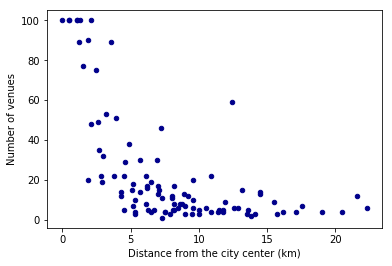

In [999]:
distance_vs_venues = dist_venues_2.plot.scatter(x='Distance', y='Venue',c='DarkBlue')

# Set the x-axis label
distance_vs_venues.set_xlabel("Distance from the city center (km)")

# Set the y-axis label
distance_vs_venues.set_ylabel("Number of venues")

### 3.2 Data preparation

Let's remove all of the stations with 5 or less venues since it's most likely not enough to get reliable results. Those stations can be placed in their own "cluster" and are suitable for people who would like to move to a calm place with almost no venues.

I start with creating a new dataframe where all the "calm" stations (i.e. with 5 or less values) are represented:

In [1035]:
calm_stations=venues_grouped
calm_stations.drop(calm_stations[calm_stations['Venue'] > 5].index, inplace=True)
calm_stations=calm_stations.drop('Venue',1)
calm_stations.head()

,Metro station
0,Abrahamsberg
2,Alby
5,Axelsberg
9,Björkhagen
16,Enskede gård


In [1001]:
calm_stations.shape

(30, 1)

Now let's create a new dataframe where all the metro stations with 5 or less venues are removed, i.e. the dataframe that will be used for clustering:

In [1002]:
sthlm_venues_2 = sthlm_venues_1.groupby('Metro station').filter(lambda x : len(x)>5)

Let's get the number of rows that are left:

In [1008]:
sthlm_venues_2.shape

(2216, 7)

Let's see how many unique categories there are in the dataframe:

In [1010]:
print('There are {} uniques categories.'.format(len(sthlm_venues_2['Category'].unique())))

There are 248 uniques categories.


In order to prepare the dataset for clustering and deal with categorical values (venue categories),
let's perform one hot encoding:

In [1012]:
# one hot encoding
sthlm_onehot = pd.get_dummies(sthlm_venues_2[['Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
sthlm_onehot['Metro station'] = sthlm_venues_2['Metro station'] 

# move neighbourhood column to the first column
fixed_columns = [sthlm_onehot.columns[-1]] + list(sthlm_onehot.columns[:-1])
sthlm_onehot = sthlm_onehot[fixed_columns]

sthlm_onehot.head()

,Metro station,Accessories Store,Advertising Agency,American Restaurant,Amphitheater,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Burger Joint,Bus Line,Bus Station,Bus Stop,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Castle,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,City Hall,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cupcake Shop,Currency Exchange,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Dive Bar,Doctor's Office,Dog Run,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,General College & University,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Lebanese Restaurant,Library,Light Rail Station,Liquor Store,Lounge,Martial Arts Dojo,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,Newsstand,Nightclub,Noodle House,Office,Opera House,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Gym,Outdoor Sculpture,Pakistani Restaurant,Palace,Park,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Pub,Ramen Restaurant,Record Shop,Restaurant,Road,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tiki Bar,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Slussen,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

Just to double-check that everything is OK (2216 rows and 249 columns are expected):

In [1013]:
sthlm_onehot.shape

(2216, 249)

Great! Now let's normamilze the data by grouping rows by metro station and taking the mean of the frequency of occurrence of each category:

In [1015]:
sthlm_grouped = sthlm_onehot.groupby('Metro station').mean().reset_index()
sthlm_grouped.head()

,Metro station,Accessories Store,Advertising Agency,American Restaurant,Amphitheater,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Burger Joint,Bus Line,Bus Station,Bus Stop,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Castle,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,City Hall,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cupcake Shop,Currency Exchange,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Dive Bar,Doctor's Office,Dog Run,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,General College & University,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Lebanese Restaurant,Library,Light Rail Station,Liquor Store,Lounge,Martial Arts Dojo,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,Newsstand,Nightclub,Noodle House,Office,Opera House,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Gym,Outdoor Sculpture,Pakistani Restaurant,Palace,Park,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Pub,Ramen Restaurant,Record Shop,Restaurant,Road,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tiki Bar,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Akalla,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.076923,0.000000,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.153846,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,

Let's double-check that everything is OK again (70 rows, one for each metro station, and 249 columns, one for each venue category, are expected):

In [1017]:
sthlm_grouped.shape

(70, 249)

### 3.3 Clustering
#### 3.3.1 Finding the optimal number of clusters
In order to try to determine the optimal number of clusters (k), two different methods are going to be used –
the elbow method and the silhouette score. Both of the analyses will be run on a range between 2
and 9 clusters.

Let's start with the elbow method:

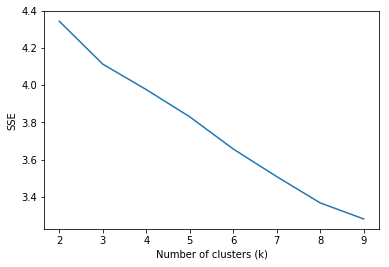

In [1020]:
sthlm_grouped_clustering = sthlm_grouped.drop('Metro station', 1)
sse = {}
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=1).fit(sthlm_grouped_clustering)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE")
plt.show()

The “elbow” is not very clear but a slight bend in the curve at k = 3 can be an indication that this might be the best number of clusters.

Let's try the silhouette method:

In [1022]:
for n_clusters in range(2, 10):
    clusterer = KMeans(n_clusters=n_clusters, max_iter=1000, random_state=1)
    preds = clusterer.fit_predict(sthlm_grouped_clustering)
    centers = clusterer.cluster_centers_
    score = silhouette_score (sthlm_grouped_clustering, preds, metric='euclidean')
    print(n_clusters, round(score,4))

2 0.1232
3 0.1523
4 0.1061
5 0.0117
6 0.0192
7 0.1298
8 0.0833
9 0.131


The silhouette method indicates that the optimal number of clusters for the dataset is k = 3 since it has the highest score.

#### 3.3.2 K-Means clustering

Let's run K-Means clustering with 3 clusters: 

In [1023]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sthlm_grouped_clustering)

# Let's see how many stations belong to each cluster
print(Counter(kmeans.labels_))

Counter({2: 32, 0: 26, 1: 12})


Let's visualize the result on the map and start with combining the result of the clustering with the metro stations that have too few venues. That is in order to visualize everything on the same map.

In [1043]:
# Create a new dataframe and add a new "cluster" that is not equal to any of the existing clusters,
# just in order to be able to select by this cluster later in the project
calm_stations_1 = calm_stations
calm_stations_1['Cluster Labels'] = kclusters

# Add coordinates to the dataset above and clean the unnecessary information (Distance)  
calm_stations_1 = calm_stations_1.join(metro_st_4.set_index('Station'), on='Metro station')
calm_stations_1.drop("Distance", axis = 1, inplace = True)
calm_stations_1.head()

,Metro station,Cluster Labels,Longitude,Latitude
0,Abrahamsberg,3,17.952950,59.336680
2,Alby,3,17.845332,59.239498
5,Axelsberg,3,17.974920,59.304364
9,Björkhagen,3,18.115520,59.291114
16,Enskede gård,3,18.070296,59.289397


Now let's do the same procedure for the clustered metro stations and create a dataframe:

In [1056]:
# add clustering labels
sthlm_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

#create new dataframe for the clustered stations (as the opposite to the stations in the dataframe above)
clustered_stations = sthlm_grouped

# Add coordinates to the dataset above
clustered_stations = clustered_stations.join(metro_st_4.set_index('Station'), on='Metro station')
clustered_stations.head()

,Cluster Labels,Metro station,Accessories Store,Advertising Agency,American Restaurant,Amphitheater,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Burger Joint,Bus Line,Bus Station,Bus Stop,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Castle,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,City Hall,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cupcake Shop,Currency Exchange,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Dive Bar,Doctor's Office,Dog Run,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,General College & University,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Lebanese Restaurant,Library,Light Rail Station,Liquor Store,Lounge,Martial Arts Dojo,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,Newsstand,Nightclub,Noodle House,Office,Opera House,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Gym,Outdoor Sculpture,Pakistani Restaurant,Palace,Park,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Pub,Ramen Restaurant,Record Shop,Restaurant,Road,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tiki Bar,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Longitude,Latitude,Distance
0,2,Akalla,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.076923,0.000000,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.153846,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

Let's combine the clustered stations and the "calm" stations in one dataset that is going to be used in order to create the map:

In [1064]:
sthlm_merged = pd.concat([clustered_stations, calm_stations_1], axis=0, ignore_index=True, sort=False)
sthlm_merged_1 = sthlm_merged[['Metro station','Cluster Labels','Latitude','Longitude']]
sthlm_merged_1.head()

,Metro station,Cluster Labels,Latitude,Longitude
0,Akalla,2,59.414814,17.912796
1,Alvik,2,59.333633,17.980269
2,Aspudden,2,59.306449,18.001447
3,Bagarmossen,1,59.276263,18.131467
4,Bandhagen,2,59.270403,18.049486


Finally, let's create the map where the real clusters will be red, green and blue and the calm stations will be marked with black cirkles:

In [1065]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set the color scheme for the clusters and add markers to the map
colors = ['red','green','blue','black']
fillers = ['red','green','blue','beige']

for lat, lon, poi, cluster in zip(sthlm_merged_1['Latitude'], sthlm_merged_1['Longitude'], sthlm_merged_1['Metro station'], sthlm_merged_1['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors[cluster],
        fill=True,
        fill_color=fillers[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

To describe the clusters, let's calculate how many venues on the main category level there are in each cluster:

In [1133]:
# Create new dataframe with only the cluster labels and metro stations:
cluster_info=sthlm_merged_1[['Cluster Labels','Metro station']]

# Merge this information with the dataframe that contains all of the venues and columns of the interest:
describe_clusters=main_cat
describe_clusters=describe_clusters.merge(cluster_info, how="left", on="Metro station")
describe_clusters_1=describe_clusters[['Metro station','Category','Main category','Cluster Labels']]

# Remove the data that we don't need (i.e. the stations excluded from the clustering)
describe_clusters_1.drop(describe_clusters_1[describe_clusters_1['Cluster Labels'] == 3].index, inplace = True) 
describe_clusters_1.head()

,Metro station,Category,Main category,Cluster Labels
0,Slussen,Beer Bar,Nightlife Spot,0
1,Slussen,Beer Garden,Nightlife Spot,0
2,Slussen,Pub,Nightlife Spot,0
3,Slussen,Theater,Arts & Entertainment,0
4,Slussen,Pub,Nightlife Spot,0


Double-check that the new dataframe has 2216 rows:

In [1134]:
describe_clusters_1.shape

(2216, 4)

Great! Now let's calculate ow many venues on the main category level there are in each cluster and the percentage:

In [1185]:
main_cat_clusters=describe_clusters_1.groupby(['Cluster Labels','Main category'])['Category'].count().reset_index()
main_cat_clusters=main_cat_clusters.sort_values(by=['Category'], ascending=False)
main_cat_cluster_1=main_cat_clusters[main_cat_clusters['Cluster Labels']==0]
main_cat_cluster_1['Percent'] = round(main_cat_cluster_1['Category']/main_cat_cluster_1['Category'].sum()*100,1)
main_cat_cluster_1=main_cat_cluster_1.sort_values('Main category', ascending=True)
main_cat_cluster_1

,Cluster Labels,Main category,Category,Percent
0,0,Arts & Entertainment,85,5.4
1,0,College & University,3,0.2
2,0,Food,854,53.8
3,0,Nightlife Spot,142,8.9
4,0,Outdoors & Recreation,143,9.0
5,0,Professional & Other Places,22,1.4
6,0,Shop & Service,247,15.6
7,0,Travel & Transport,91,5.7


Let's repeat the same calculation for the rest of the clusters:

In [1187]:
main_cat_cluster_2=main_cat_clusters[main_cat_clusters['Cluster Labels']==1]
main_cat_cluster_2['Percent'] = round(main_cat_cluster_2['Category']/main_cat_cluster_2['Category'].sum()*100,1)
main_cat_cluster_2=main_cat_cluster_2.sort_values('Main category', ascending=True)
main_cat_cluster_2

,Cluster Labels,Main category,Category,Percent
8,1,Arts & Entertainment,7,5.3
9,1,Food,64,48.1
10,1,Nightlife Spot,4,3.0
11,1,Outdoors & Recreation,23,17.3
12,1,Professional & Other Places,1,0.8
13,1,Shop & Service,24,18.0
14,1,Travel & Transport,10,7.5


In [1188]:
main_cat_cluster_3=main_cat_clusters[main_cat_clusters['Cluster Labels']==2]
main_cat_cluster_3['Percent'] = round(main_cat_cluster_3['Category']/main_cat_cluster_3['Category'].sum()*100,1)
main_cat_cluster_3=main_cat_cluster_3.sort_values('Main category', ascending=True)
main_cat_cluster_3

,Cluster Labels,Main category,Category,Percent
15,2,Arts & Entertainment,16,3.2
16,2,College & University,1,0.2
17,2,Food,214,43.1
18,2,Nightlife Spot,9,1.8
19,2,Outdoors & Recreation,76,15.3
20,2,Professional & Other Places,2,0.4
21,2,Shop & Service,129,26.0
22,2,Travel & Transport,49,9.9


Let's get the most common venues on the lower level of classification and their occurence for each cluster:

In [1196]:
detailed_cat_clusters=describe_clusters_1.groupby(['Cluster Labels','Category'])['Main category'].count().reset_index()
detailed_cat_clusters=detailed_cat_clusters.sort_values(by=['Main category'], ascending=False)
detailed_cat_clusters[detailed_cat_clusters['Cluster Labels']==0].head(7)

,Cluster Labels,Category,Main category
181,0,Scandinavian Restaurant,96
37,0,Café,84
109,0,Hotel,55
15,0,Bakery,54
119,0,Italian Restaurant,53
51,0,Coffee Shop,45
99,0,Gym / Fitness Center,37


In [1197]:
detailed_cat_clusters[detailed_cat_clusters['Cluster Labels']==1].head(7)

,Cluster Labels,Category,Main category
247,1,Pizza Place,25
236,1,Grocery Store,17
221,1,Bakery,8
253,1,Scandinavian Restaurant,7
226,1,Bus Stop,7
238,1,Gym / Fitness Center,6
258,1,Thai Restaurant,5


In [1198]:
detailed_cat_clusters[detailed_cat_clusters['Cluster Labels']==2].head(7)

,Cluster Labels,Category,Main category
279,2,Café,32
307,2,Grocery Store,30
341,2,Pizza Place,28
287,2,Convenience Store,21
309,2,Gym / Fitness Center,19
361,2,Sushi Restaurant,19
366,2,Thai Restaurant,17


## 4. Results
Different clusters can be categorized as followed:
• Cluster 1 (k = 1, red) has the highest number of venues and is mainly located in the city
center. On average, there are more than 60 venues surrounding every metro station
within this cluster. The most common categories of venues beginning with the largest
category are Food, Shop & Service, Outdoors & Recreation, Nightlife Spot, Travel &
Transport and Arts & Entertainment. Within category Food, the most common venues are
Scandinavian restaurants, cafés, bakeries, Italian restaurants and coffee shops.
• Cluster 2 (k = 2, green) has the lowest number of venues among the clusters, with
approximately only 11 venues per metro station on average. This cluster is located
outside the central part of Stockholm. The most common categories of venues are Food,
Shop & Service and Outdoors & Recreation. Within category Food, the most common
venues are pizza places, bakeries, Scandinavian and Thai restaurants.
• Cluster 3 (k = 3, blue) has an average of approximately 16 venues per metro station and
is located mainly outside of the city center. The most common categories of venues are
Food, Shop & Service, Outdoors & Recreation and Travel & Transport. Within category
Food, the most common venues are cafés, pizza places, Sushi and Thai restaurants.
For someone who prefers to move to calm areas with very few venues (5 or less), there are 30
neighborhoods in Stockholm that might fit. Please see Appendix for the list of the metro stations
and information about their cluster.

## 5. Discussion
The purpose of this study was to cluster different neighborhoods in Stockholm based on areas
surrounding every metro station. For that, Foursquare venue data was used. Foursquare is
mainly focused on food places and for someone who is interested in other kind of parameters,
e.g. housing prices or what schools are available, it would be interesting to add this kind of
information to the analysis.
Another possible development is to include a larger area than just Stockholm municipality and
find another way of grouping neighborhoods. This could potentially be valuable for someone who
prefers riding a bike or using a car instead of public transportation and would like to discover
other neighborhoods than just around the metro stations.
## 6. Conclusion
In this study, I tried to cluster different neighborhoods of Stockholm in order to help someone
who are moving to Stockholm to find a place that would fit their lifestyle and preferences.
Three clusters were identified along with a group of metro stations that don’t have that many
venues around them. The main differences between the clusters is the average number of
venues per neighborhood and what venues are the most common ones in the city center
compared to the other areas in Stockholm. Although, when it comes to the most common
categories of venues, all the clusters look similar to each other, indicating that Stockholm is quite
homogeneous in terms of available venue categories.